In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(os.getcwd())

In [3]:
#Author: Ioannis Anastopoulos
from sklearn.metrics import r2_score,confusion_matrix, accuracy_score,roc_curve,auc,precision_recall_fscore_support,f1_score
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def F_score(Y_true,predict_classes ,classes=None, plot=False,average=None):
    if classes is None:
        classes=range(len(set(Y_true)))
    eval_metrics_matrix=precision_recall_fscore_support(Y_true,predict_classes,labels=classes,average=average)
    f_score_df=pd.DataFrame(eval_metrics_matrix[2], columns=['F_score'],index=classes)
    f_score_df=f_score_df.drop_duplicates()

    if plot:
        plt.figure(figsize=(10,10))
        ax=f_score_df.plot(kind='bar', figsize=(7,10))
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.title('F1_score')
        plt.show()
        plt.close()
    return f_score_df

def confusion(Y_true,predict_classes,classes=None,plot=False, title='Confusion Matrix',fontsize=16,cmap='tab20',normalize=False):

    if classes is None:
        classes=range(len(set(predict_classes)))

    conf_matrix=confusion_matrix(Y_true, predict_classes, labels=classes)

    if normalize:
        total=conf_matrix.sum(axis=0) #summing actual predictions
        conf_matrix= conf_matrix/total

    df_cm = pd.DataFrame(conf_matrix, index=classes,
                  columns=classes)
    #sns.set(font_scale=5)#for label size
    if plot:
        plt.figure(figsize=(7,5))
        sns.heatmap(df_cm, annot=True,annot_kws={"size":fontsize },cmap=cmap,fmt='g')# font size
        #fig=conf_hm.get_figure()
        plt.yticks(fontsize=fontsize+4)
        plt.ylabel("True Labels", fontsize=13)
        plt.xlabel("Predicted Labels", fontsize=13)
        plt.xticks(fontsize=fontsize+4)
        plt.title(title, fontsize=fontsize+10)
        #fig.savefig(out,dpi=300)
        plt.show()
        plt.close()

    return conf_matrix

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def ROC(y_true, y_pred,classes=None,title=None,plot=False):

    plt.figure(figsize=(10,10))
    lw=4

    if isinstance(y_true, pd.DataFrame):
        y_true=y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred=y_pred.values


    if classes is None:
        classes=set(list(y_true.flatten())) #removing dups, and i think itll only work for binary cases

    if len(classes)>2:
        #y_true = to_categorical(y_true, len(classes))
        #y_pred = to_categorical(y_pred, len(classes))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i,cl in enumerate(classes):
            fpr[cl], tpr[cl], _ = roc_curve(y_true[:,i], y_pred[:, i])
            roc_auc[cl] = auc(fpr[cl], tpr[cl])
        
        if plot: 
            colors = plt.cm.get_cmap('tab20',len(classes)) #best line of code IN THE UNIVERSE

            for i, color in zip(range(len(classes)), colors.colors):
                cl = classes[i]
                plt.plot(fpr[cl], tpr[cl], color=colors.colors[i], lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(cl, roc_auc[cl]))
            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([-0.03, 1.05])
            plt.ylim([-0.03, 1.05])
            plt.xlabel('False Positive Rate', fontsize=10)
            plt.ylabel('True Positive Rate',fontsize=10)
            plt.title(title, fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend(loc="lower right",prop={'size': 15})
            #plt.savefig('/projects/sysbio/users/ianastop/cm_region_results/plots/%s_ROC.png'%self.out,dpi=300)
            plt.show()
            plt.close()

        return (fpr, tpr, roc_auc)

    else:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        if plot:
            plt.plot(fpr, tpr, color='darkorange', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)

            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([-0.03, 1.05])
            plt.ylim([-0.03, 1.05])
            plt.xlabel('False Positive Rate', fontsize=10)
            plt.ylabel('True Positive Rate',fontsize=10)
            plt.title(title, fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend(loc="lower right",prop={'size': 10})
            #plt.savefig('/projects/sysbio/users/ianastop/cm_region_results/plots/%s_ROC.png'%self.out,dpi=300)
            return( fpr, tpr, roc_auc)
            plt.show()
            plt.close()
        print(fpr, tpr)
        return fpr,tpr,roc_auc



def regression_eval(y_true,y_pred, axis=None):
    '''
    Function computes pearson, r2 and rmse row wise or column wise
    Returns a list for each metric for each row or column

    axis =0/1 if the vector predicted has multiple rows and columns: for expression matrices
    if the vectors has multiple samples predicted for 1 variable : for drug response vector of each drug individually
    '''
    #calculating metrics on a per sample basis
    if axis ==0:
        r_list = []
        r2_list = []
        rmse_list = []
        for i, vec in enumerate(y_true):
            r_list +=[pearsonr(vec, y_pred[i])[0]]
            r2_list += [r2_score(vec, y_pred[i])]
            rmse_list += [rmse(vec,y_pred[i])]
        r = np.mean(r_list)
        r2 = np.mean(r2_list)
        rmse_score = np.mean(rmse_list)
    elif axis == 1:
        r_list = []
        r2_list = []
        rmse_list = []
        for i, vec in enumerate(y_true.T):
            r_list +=[pearsonr(vec, y_pred.T[i])[0]]
            r2_list += [r2_score(vec, y_pred.T[i])]
            rmse_list += [rmse(vec,y_pred.T[i])]
        r = np.mean(r_list)
        r2 = np.mean(r2_list)
        rmse_score = np.mean(rmse_list)
    elif axis is None:
        r, _ = pearsonr(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse_score = rmse(y_true, y_pred)
    return r,r2,rmse_score

def classification_eval(y_true, y_pred,classes=None):
    acc = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = ROC(y_true, y_pred,classes=classes)[-1]
    
    return acc, f1, roc_auc
        
def node_classification_eval():
    pass 


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
fpkm_polya_df = pd.read_csv('../results/pbta-gene-expression-rsem-fpkm-collapsed.polya_log2tpm_plus_1.balanced_maxdepth1_results.tsv', index_col=0, sep='\t')
fpkm_ribod_df = pd.read_csv('../results/pbta-gene-expression-rsem-fpkm-collapsed.stranded_log2tpm_plus_1.balanced_maxdepth1_results.tsv', index_col=0, sep='\t')
fpkm_true_labels = fpkm_polya_df.shape[0]*[0]+fpkm_ribod_df.shape[0]*[1]
fpkm_df = pd.concat([fpkm_polya_df, fpkm_ribod_df], axis=0)
fpkm_pred_labels = fpkm_df.Ribo.values
fpkm_pred_labelname = list(map(lambda x:"RiboD" if x==1 else "PolyA", fpkm_pred_labels))

In [5]:
fpkm_df.shape # total number of samples
# sample number are the same for tpm file

(1028, 3)

In [6]:
fpkm_polya_df.shape

(58, 3)

In [7]:
fpkm_ribod_df.shape

(970, 3)

In [8]:
acc, f1, roc_auc = classification_eval(fpkm_true_labels, fpkm_pred_labels, classes={0,1})
print('Accuracy: {}\nF1-score: {}\nROC_AUC: {}'.format(acc, f1, roc_auc))

[0. 0. 1.] [0. 1. 1.]
Accuracy: 1.0
F1-score: 1.0
ROC_AUC: 1.0


<Figure size 720x720 with 0 Axes>

(array([0., 0., 1.]), array([0., 1., 1.]), 1.0)

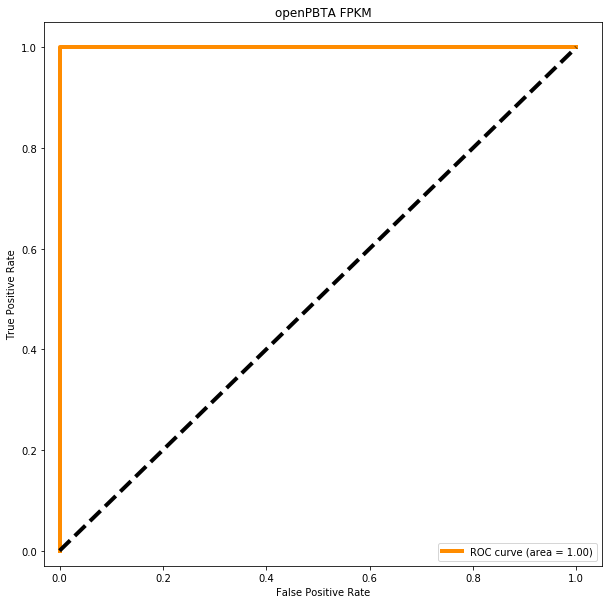

In [9]:
ROC(fpkm_true_labels, fpkm_pred_labels, classes={0,1}, plot=True, title = 'openPBTA FPKM')

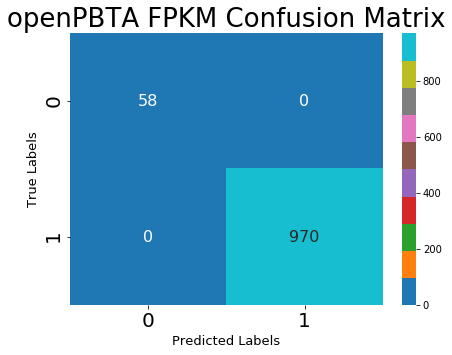

array([[ 58,   0],
       [  0, 970]])

In [10]:
confusion(fpkm_true_labels, list(fpkm_pred_labels), plot=True, title='openPBTA FPKM Confusion Matrix',fontsize=16,normalize=False, cmap='tab10')


In [11]:
tpm_polya_df = pd.read_csv('../results/pbta-gene-expression-kallisto.polya_log2tpm_plus_1.balanced_maxdepth1_results.tsv', index_col=0, sep='\t')
tpm_ribod_df = pd.read_csv('../results/pbta-gene-expression-kallisto.stranded_log2tpm_plus_1.balanced_maxdepth1_results.tsv', index_col=0, sep='\t')
tpm_true_labels = tpm_polya_df.shape[0]*[0]+tpm_ribod_df.shape[0]*[1]
tpm_df = pd.concat([tpm_polya_df, tpm_ribod_df], axis=0)
tpm_pred_labels = tpm_df.Ribo.values

In [12]:
acc, f1, roc_auc = classification_eval(tpm_true_labels, tpm_pred_labels, classes={0,1})
print('Accuracy: {}\nF1-score: {}\nROC_AUC: {}'.format(acc, f1, roc_auc))

[0. 0. 1.] [0.         0.99793814 1.        ]
Accuracy: 0.9980544747081712
F1-score: 0.9980699583276249
ROC_AUC: 0.9989690721649485


<Figure size 720x720 with 0 Axes>

In [13]:
tpm_pred_proba = tpm_df.Proba_1.values

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

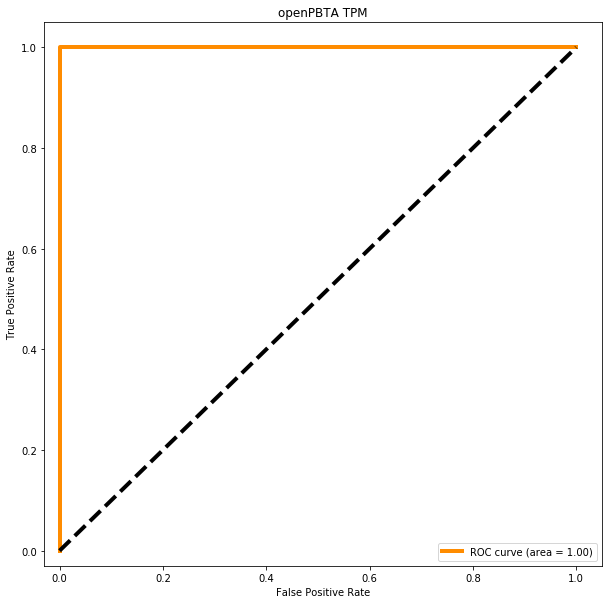

In [14]:
ROC(tpm_true_labels, tpm_pred_proba, classes={0,1}, plot=True, title='openPBTA TPM')

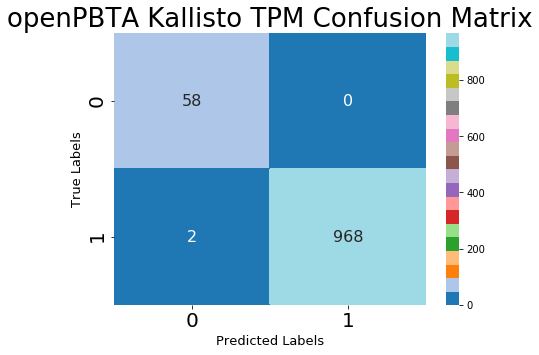

array([[ 58,   0],
       [  2, 968]])

In [15]:
confusion(tpm_true_labels, list(tpm_pred_labels), plot=True, title='openPBTA Kallisto TPM Confusion Matrix',fontsize=16,cmap='tab20',normalize=False)
